In [ ]:
#| hide
!pip install -Uqq nixtla

/usr/lib/python3.10/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


In [ ]:
#| hide
from nixtla.utils import in_colab
from nbdev import show_doc

In [ ]:
#| hide
IN_COLAB = in_colab()
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Missing Values

`TimeGPT` requires time series data that doesn't have any missing values. It is possible to have multiple series that begin and end on different dates, but it is essential that each series contains uninterrupted data for its given time frame.

In this tutorial, we will show you how to deal with missing values in `TimeGPT`. 

**Outline** 

1. [Load Data](#load-data) 

2. [Get Started with TimeGPT](#get-started-with-timegpt)

3. [Visualize Data](#visualize-data)

4. [Fill Missing Values](#fill-missing-values)

5. [Forecast with TimeGPT](#forecast-with-timegpt)

6. [Important Considerations](#important-considerations)

7. [References](#references)

This work is based on skforecast's [Forecasting Time Series with Missing Values](https://cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values) tutorial. 

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/15_missing_values')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/15_missing_values.ipynb)

## Load Data

We will first load the data using `pandas`. This dataset represents the daily number of bike rentals in a city. The column names are in Spanish, so we will rename them to `ds` for the dates and `y` for the number of bike rentals.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/usuarios_diarios_bicimad.csv')
df = df[['fecha', 'Usos bicis total día']] # select date and target variable 
df.rename(columns={'fecha': 'ds', 'Usos bicis total día': 'y'}, inplace=True) 
df.head()

,ds,y
0,2014-06-23,99
1,2014-06-24,72
2,2014-06-25,119
3,2014-06-26,135
4,2014-06-27,149


For convenience, we will convert the dates to timestamps and assign a unique id to the series. Although we only have one series in this example, when dealing with multiple series, it is necessary to assign a unique id to each one.

In [ ]:
df['ds'] = pd.to_datetime(df['ds']) 
df['unique_id'] = 'id1'
df = df[['unique_id', 'ds', 'y']]

Now we will separate the data in a training and a test set. We will use the last 93 days as the test set. 

In [ ]:
train_df = df[:-93] 
test_df = df[-93:] 

We will now introduce some missing values in the training set to demonstrate how to deal with them. This will be done as in the [skforecast](https://cienciadedatos.net/documentos/py46-forecasting-time-series-missing-values) tutorial. 

In [ ]:
mask = ~((train_df['ds'] >= '2020-09-01') & (train_df['ds'] <= '2020-10-10')) &  ~((train_df['ds'] >= '2020-11-08') & (train_df['ds'] <= '2020-12-15'))

train_df_gaps = train_df[mask]

## Get Started with TimeGPT

Before proceeding, we will instantiate the `NixtlaClient` class, which provides access to all the methods from `TimeGPT`. To do this, you will need a Nixtla API key.

In [ ]:
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, set the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide 
if not IN_COLAB:
    nixtla_client = NixtlaClient()

To learn more about how to set up your API key, please refer to the [Setting Up Your API Key](https://docs.nixtla.io/docs/getting-started-setting_up_your_api_key) tutorial. 

## Visualize Data

We can visualize the data using the `plot` method from the `NixtlaClient` class. This method has an `engine` argument that allows you to choose between different plotting libraries. Default is `matplotlib`, but you can also use `plotly` for interactive plots.

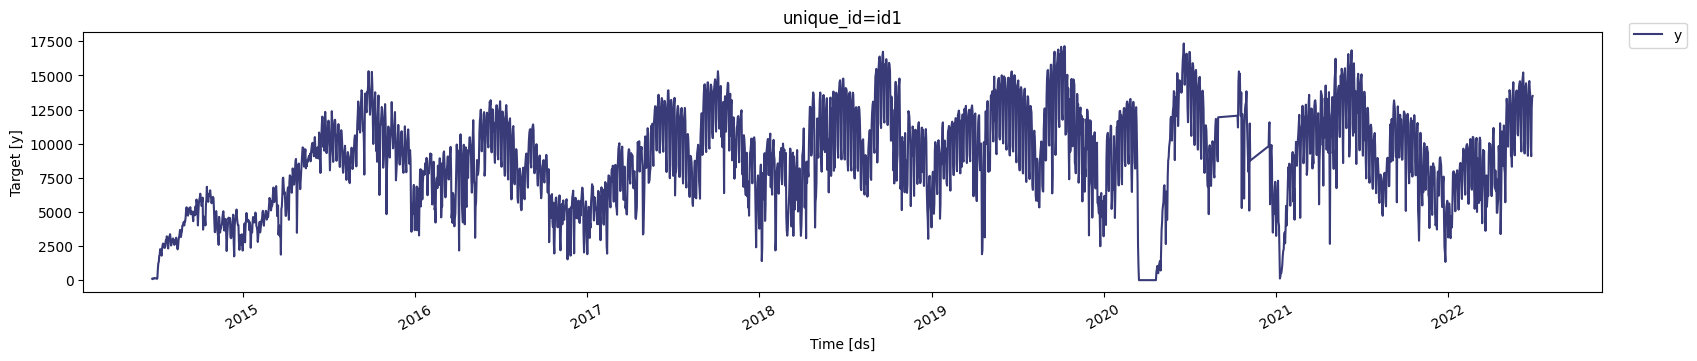

In [ ]:
nixtla_client.plot(train_df_gaps)

Note that there are two gaps in the data: from September 1, 2020, to October 10, 2020, and from November 8, 2020, to December 15, 2020. To better visualize these gaps, you can use the `max_insample_length` argument of the `plot` method or you can simply zoom in on the plot.

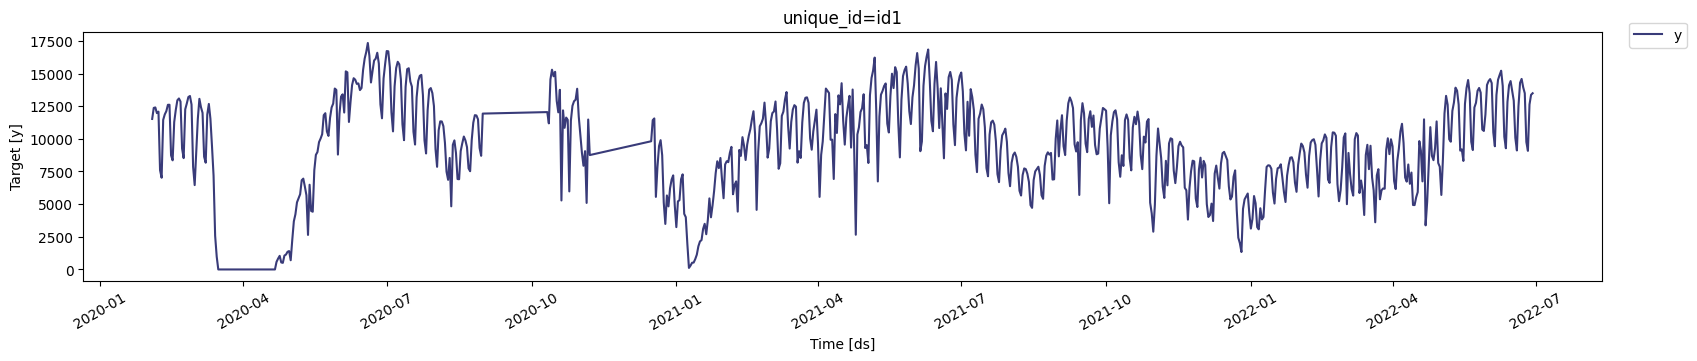

In [ ]:
nixtla_client.plot(train_df_gaps, max_insample_length=800)

Additionally, notice a period from March 16, 2020, to April 21, 2020, where the data shows zero rentals. These are not missing values, but actual zeros corresponding to the COVID-19 lockdown in the city.

## Fill Missing Values

Before using `TimeGPT`, we need to ensure that: 

1. All timestamps from the start date to the end date are present in the data. 

2. The target column contains no missing values. 

To address the first issue, we will use the `fill_gaps` function from [`utilsforecast`](https://nixtlaverse.nixtla.io/utilsforecast/index.html), a Python package from Nixtla that provides essential utilities for time series forecasting, such as functions for data preprocessing, plotting, and evaluation.

The `fill_gaps` function will fill in the missing dates in the data. To do this, it requires the following arguments:

- `df`: The DataFrame containing the time series data.

- `freq` (str or int): The frequency of the data. 

In [ ]:
from utilsforecast.preprocessing import fill_gaps

In [ ]:
print('Number of rows before filling gaps:', len(train_df_gaps))
train_df_complete = fill_gaps(train_df_gaps, freq='D')
print('Number of rows after filling gaps:', len(train_df_complete))

Number of rows before filling gaps: 2851
Number of rows after filling gaps: 2929


> NOTE:
>
> In this tutorial, the data contains only one time series. However, TimeGPT supports passing multiple series to the model. In this case, none of the time series can have missing values from their individual earliest timestamp until their individual lastest timestamp. If these individual time series have missing values, the user must decide how to fill these gaps for the individual time series. The [`fill_gaps`](https://nixtlaverse.nixtla.io/utilsforecast/preprocessing.html#fill-gaps) function provides a couple of additional arguments to assist with this (refer to the documentation for complete details), namely `start` and `end`

In [ ]:
show_doc(fill_gaps)

---

[source](https://github.com/Nixtla/utilsforecast/blob/main/utilsforecast/preprocessing.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### fill_gaps

>      fill_gaps (df:~DFType, freq:Union[str,int],
>                 start:Union[str,int,datetime.date,datetime.datetime]='per_seri
>                 e',
>                 end:Union[str,int,datetime.date,datetime.datetime]='global',
>                 id_col:str='unique_id', time_col:str='ds')

*Enforce start and end datetimes for dataframe.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | DFType |  | Input data |
| freq | Union |  | Series' frequency |
| start | Union | per_serie | Initial timestamp for the series.<br>    * 'per_serie' uses each serie's first timestamp<br>    * 'global' uses the first timestamp seen in the data<br>    * Can also be a specific timestamp or integer, e.g. '2000-01-01', 2000 or datetime(2000, 1, 1) |
| end | Union | global | Initial timestamp for the series.<br>    * 'per_serie' uses each serie's last timestamp<br>    * 'global' uses the last timestamp seen in the data<br>    * Can also be a specific timestamp or integer, e.g. '2000-01-01', 2000 or datetime(2000, 1, 1) |
| id_col | str | unique_id | Column that identifies each serie. |
| time_col | str | ds | Column that identifies each timestamp. |
| **Returns** | **DFType** |  | **Dataframe with gaps filled.** |

Now we need to decide how to fill the missing values in the target column. In this tutorial, we will use interpolation, but it is important to consider the specific context of your data when selecting a filling strategy. For example, if you are dealing with daily retail data, a missing value most likely indicates that there were no sales on that day, and you can fill it with zero. Conversely, if you are working with hourly temperature data, a missing value probably means that the sensor was not functioning, and you might prefer to use interpolation to fill the missing values.

In [ ]:
train_df_complete['y'] = train_df_complete['y'].interpolate(method='linear', limit_direction='both')

train_df_complete.isna().sum() # check if there are any missing values

unique_id    0
ds           0
y            0
dtype: int64

## Forecast with TimeGPT

We are now ready to use the `forecast` method from the `NixtlaClient` class. This method requires the following arguments:

- `df`: The DataFrame containing the time series data

- `h`: (int) The forecast horizon. In this case, it is 93 days.

- `model` (str): The model to use. Default is `timegpt-1`, but since the forecast horizon exceeds the frequency of the data (daily), we will use `timegpt-1-long-horizon`. To learn more about this, please refer to the [Forecasting on a Long Horizon](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) tutorial.

In [ ]:
fcst = nixtla_client.forecast(train_df_complete, h=len(test_df), model='timegpt-1-long-horizon')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
> 
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`. 
> 
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

We can use the `plot` method to visualize the `TimeGPT` forecast and the test set. 

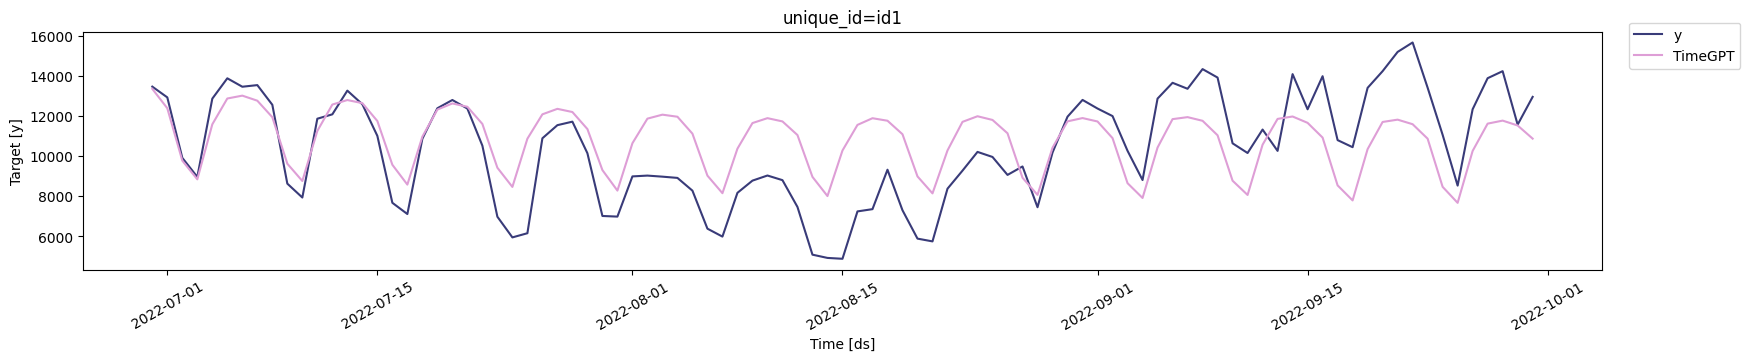

In [ ]:
nixtla_client.plot(test_df, fcst)

Next, we will use the `evaluate` function from `utilsforecast` to compute the Mean Average Error (MAE) of the TimeGPT forecast. Before proceeding, we need to convert the dates in the forecast to timestamps so we can merge them with the test set.

The `evaluate` function requires the following arguments:

- `df`: The DataFrame containing the forecast and the actual values (in the `y` column).

- `metrics` (list): The metrics to be computed.

In [ ]:
from utilsforecast.evaluation import evaluate 
from utilsforecast.losses import mae 

In [ ]:
fcst['ds'] = pd.to_datetime(fcst['ds'])

result = test_df.merge(fcst, on=['ds', 'unique_id'], how='left')
result.head()


,unique_id,ds,y,TimeGPT
0,id1,2022-06-30,13468,13357.357
1,id1,2022-07-01,12932,12390.052
2,id1,2022-07-02,9918,9778.649
3,id1,2022-07-03,8967,8846.637
4,id1,2022-07-04,12869,11589.071


In [ ]:
evaluate(result, metrics=[mae])

,unique_id,metric,TimeGPT
0,id1,mae,1824.693059


## Important Considerations 

The key takeaway from this tutorial is that `TimeGPT` requires time series data without missing values. This means that: 

1. Given the frequency of the data, the timestamps must be continuous, with no gaps between the start and end dates.

2. The data must not contain missing values (NaNs). 

We also showed that `utilsforecast` provides a convenient function to fill missing dates and that you need to decide how to address the missing values. This decision depends on the context of your data, so be mindful when selecting a filling strategy, and choose the one you think best reflects reality.

Finally, we also demonstrated that `utilsforecast` provides a function to evaluate the `TimeGPT` forecast using common accuracy metrics. 

**References**

* [Joaquín Amat Rodrigo and Javier Escobar Ortiz (2022). "Exclude covid impact in time series forecasting"](https://www.cienciadedatos.net/documentos/py45-weighted-time-series-forecasting.html)